In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             accuracy_score,
                             f1_score,
                             ConfusionMatrixDisplay)

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)

import nltk
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from skorch import NeuralNetClassifier

nltk.download('punkt')
glove_filepath = 'glove.6B.300d.txt'

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kevinbrundler/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def load_glove_embeddings(filepath):
    """
    Loads GloVe embeddings from a file and returns them as a dictionary.

    The function reads the GloVe pre-trained embeddings from the specified file.
    Each line in the GloVe file contains a word followed by its corresponding
    vector of floating point numbers representing the word's embedding. The
    function processes each line, extracts the word and its vector, and stores
    them in a dictionary where the key is the word and the value is the corresponding
    embedding vector.

    Args:
        filepath (str): The path to the GloVe embeddings file. Each line of the file should
                        contain a word followed by its vector of embedding values.

    Returns:
        dict: A dictionary where keys are words (str) and values are their corresponding
              embedding vectors (numpy.ndarray).

    """

    embedding_dict = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embedding_dict[word] = vector
    return embedding_dict


embedding_dict = load_glove_embeddings(r"glove/glove.6B.300d.txt")

In [3]:
def split_data(
    df: pd.DataFrame,
    label_col: str = 'label',
    test_size: float = 0.3,
    random_state: int = None
) -> tuple[pd.DataFrame]:

    def ensure_all_labels(original_df, train_df, test_df, label_col):
        original_labels = set(original_df[label_col])
        train_labels = set(train_df[label_col])
        missing_labels = original_labels - train_labels

        if missing_labels:
            for label in missing_labels:
                missing_sample = test_df[test_df[label_col] == label].sample(n=1)
                test_df = test_df[~(test_df[label_col].isin(missing_sample.labels))]
                train_df = pd.concat([train_df, missing_sample])
        return train_df, test_df

    try:
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            stratify=df[label_col],
            random_state=random_state
        )

        train_df, test_df = ensure_all_labels(df, train_df, test_df, label_col)

    except ValueError as e:
        warnings.warn(
            f"{e} --- Falling back to random split. Consider reviewing extremely small classes."
        )

        # Fallback to random split if stratified split fails
        train_df, test_df = train_test_split(
            df,
            test_size=test_size,
            random_state=random_state
        )

        train_df, test_df = ensure_all_labels(df, train_df, test_df, label_col)

    return train_df, test_df

In [4]:
def get_sentence_embedding(sentence, embedding_dict, embedding_dim=300):
    """
    Converts a sentence into a fixed-size embedding by averaging the word embeddings.

    This function takes a sentence, tokenizes it, and looks up each token's embedding
    in the provided `embedding_dict`. If a word is not found in the embedding dictionary,
    it assigns a random vector of the specified `embedding_dim`. The resulting sentence
    embedding is the average of the word embeddings.

    Args:
        sentence (str): The input sentence to be converted into an embedding.
        embedding_dict (dict): A dictionary where the keys are words and the values are
                               their corresponding embedding vectors (typically from GloVe).
        embedding_dim (int): The dimensionality of the embeddings (default is 300).

    Returns:
        numpy.ndarray: A 1D NumPy array representing the averaged embedding of the input sentence.

    """

    tokens = word_tokenize(sentence.lower())
    embeddings = []
    for token in tokens:
        if token in embedding_dict:
            embeddings.append(embedding_dict[token])
        else:
            embeddings.append(np.random.randn(embedding_dim))
    return np.mean(embeddings, axis=0)


In [5]:
df = pd.read_csv(r'data/internal/training_data/training_data_no_duplicates_per_channel.csv')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

X_train = np.array([get_sentence_embedding(str(message), embedding_dict) for message in train_df.message])
y_train = np.array(train_df.label)

X_test = np.array([get_sentence_embedding(str(message), embedding_dict) for message in test_df.message])
y_test = np.array([test_df.label])

In [6]:
def get_device():
    """
    Determines the best available hardware device (MPS, CUDA, or CPU) to run PyTorch operations.

    This function checks for the availability of hardware acceleration on the system and returns
    the appropriate device for computation. It first checks for Metal Performance Shaders (MPS) on
    Apple devices, then for CUDA (NVIDIA GPUs), and finally defaults to the CPU if no GPU is available.

    Returns:
        torch.device: The best available device ('mps', 'cuda', or 'cpu') for PyTorch computations.
    """

    if torch.backends.mps.is_available():
        print("MPS device found, using MPS backend.\n")
        return torch.device("mps")
    elif torch.cuda.is_available():
        print(f"CUDA device found, using CUDA backend. Device: {torch.cuda.get_device_name(0)}\n")
        return torch.device("cuda")
    else:
        print("Neither MPS nor CUDA found, using CPU.\n")
        return torch.device("cpu")

In [7]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate=0.5):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc4 = nn.Linear(hidden_dim1, output_dim)

        self.dropout = nn.Dropout(dropout_rate)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self._initialize_weights()

    def _initialize_weights(self):
        # Xavier Initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1 = self.leaky_relu(self.bn1(self.fc1(x)))
        x1 = self.dropout(x1)

        x2 = self.leaky_relu(self.bn2(self.fc2(x1)))
        x2 = self.dropout(x2)

        x_residual = self.fc3(x2) + x1

        x_out = self.fc4(x_residual)
        return x_out


#############
# Grid Search
#############
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_train_np, X_valid_np, y_train_np, y_valid_np = train_test_split(
    X_train.numpy(), y_train.numpy(), test_size=0.2, random_state=42
)

net = NeuralNetClassifier(
    Classifier,
    module__input_dim=X_train.shape[1],
    module__output_dim=6,
    max_epochs=10,
    lr=5e-4,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    device=get_device(),
)

param_grid = {
    'lr': [1e-3, 1e-4],
    'module__hidden_dim1': [128, 256, 512],
    'module__hidden_dim2': [64, 128, 256],
    'module__dropout_rate': [0.4, 0.5],
    'batch_size': [32, 64]
}

gs = GridSearchCV(net, param_grid, refit=True, cv=3, scoring='f1_weighted', verbose=2)
gs.fit(X_train_np, y_train_np)

print(f"Best parameters: {gs.best_params_}")
print(f"Best cross-validation accuracy: {gs.best_score_:.4f}")

best_net = gs.best_estimator_
val_accuracy = best_net.score(X_valid_np, y_valid_np)
print(f"Validation accuracy: {val_accuracy:.4f}")


MPS device found, using MPS backend.

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/Users/kevinbrundler/Desktop/Master Project/Inference Final/Pipeline/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5226       0.6793        1.0036  1.0056
      2        0.9951       0.7273        0.8611  0.5649
      3        0.8172       0.7603        0.7742  0.5642
      4        0.7168       0.7851        0.7390  0.5351
      5        0.6505       0.7950        0.6905  0.5060
      6        0.5733       0.7967        0.6740  0.5348
      7        0.5102       0.8050        0.6680  0.4781
      8        0.4842       0.8083        0.6450  0.4510
      9        0.4491       0.7950        0.6680  0.4442
     10        0.4034       0.8033        0.6546  0.5100
[CV] END batch_size=32, lr=0.001, module__dropout_rate=0.4, module__hidden_dim1=128, module__hidden_dim2=64; total time=   7.7s
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5495       0.6496        1.0555  0.5442
      2        0.

In [8]:
##########
# Training
##########

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

input_dim = X_train.shape[1]
hidden_dim1 = 512
hidden_dim2 = 64
output_dim = 6
drop_out = 0.5

model = Classifier(input_dim, hidden_dim1, hidden_dim2, output_dim, drop_out)

device = get_device()
X_train = X_train.to(device)
y_train = y_train.to(device)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

max_grad_norm = 1.0
epochs = 10
batch_size = 64

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch in range(0, len(X_train), batch_size):
        inputs = X_train[batch:batch + batch_size]
        labels = y_train[batch:batch + batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()
    print(f'Epoch: {epoch+1}, Loss: {epoch_loss/len(X_train):.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')


/var/folders/fh/yf32rrls0pjbtmy317lvgthh0000gn/T/ipykernel_92320/3581891304.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/fh/yf32rrls0pjbtmy317lvgthh0000gn/T/ipykernel_92320/3581891304.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


MPS device found, using MPS backend.

Epoch: 1, Loss: 0.0184, Learning Rate: 0.001000
Epoch: 2, Loss: 0.0104, Learning Rate: 0.001000
Epoch: 3, Loss: 0.0086, Learning Rate: 0.001000
Epoch: 4, Loss: 0.0075, Learning Rate: 0.001000
Epoch: 5, Loss: 0.0063, Learning Rate: 0.000500
Epoch: 6, Loss: 0.0058, Learning Rate: 0.000500
Epoch: 7, Loss: 0.0049, Learning Rate: 0.000500
Epoch: 8, Loss: 0.0046, Learning Rate: 0.000500
Epoch: 9, Loss: 0.0041, Learning Rate: 0.000500
Epoch: 10, Loss: 0.0040, Learning Rate: 0.000250


MPS device found, using MPS backend.

Accuracy on test data: 84.07%


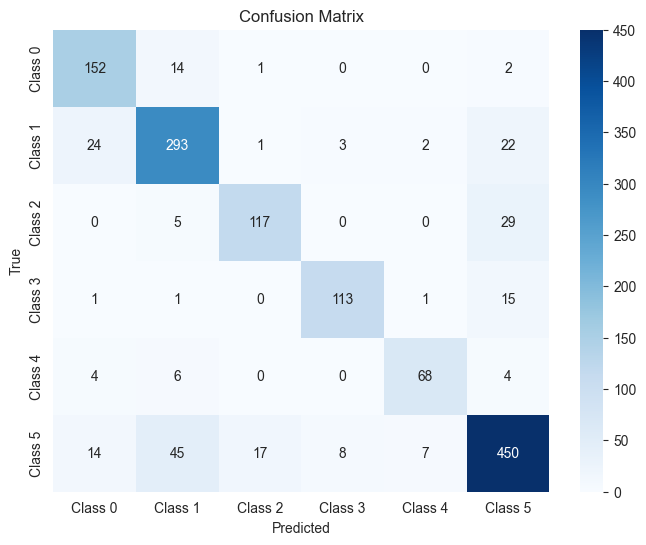

Weighted F1-Score: 84.09%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.90      0.84       169
     Class 1       0.80      0.85      0.83       345
     Class 2       0.86      0.77      0.82       151
     Class 3       0.91      0.86      0.89       131
     Class 4       0.87      0.83      0.85        82
     Class 5       0.86      0.83      0.85       541

    accuracy                           0.84      1419
   macro avg       0.85      0.84      0.84      1419
weighted avg       0.84      0.84      0.84      1419



In [9]:
############
# Evaluation
############

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

y_test = y_test.squeeze()

device = get_device()
X_test = X_test.to(device)
y_test = y_test.to(device)
model = model.to(device)

model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    correct = 0
    total = 0

    for batch in range(0, len(X_test), batch_size):
        inputs = X_test[batch:batch + batch_size]
        labels = y_test[batch:batch + batch_size]

        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / y_test.shape[0]
print(f'Accuracy on test data: {accuracy:.2f}%')

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f'Class {i}' for i in range(output_dim)],
            yticklabels=[f'Class {i}' for i in range(output_dim)])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'Weighted F1-Score: {f1*100:.2f}%')

print("\nClassification Report:")
report = classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(output_dim)])
print(report)